In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('kitCapstoneJan24_data.csv', header=0, sep=';')

In [ ]:
def month_to_datestring(month: int):
    # Startpunkt Januar 2000
    m = (month - 1) % 12 + 1
    m_string = str(m) if m > 9 else '0' + str(m)
    y = (month-1) // 12
    y_string = str(y) if y > 9 else '0' + str(y)
    
    return f'{m_string}/{y_string}'

def convert_month_to_date(df: pd.DataFrame):
    df['date'] = df['month'].apply(month_to_datestring)
    df['date'] = pd.to_datetime(df['date'], format='%m/%y')
    result = df.set_index('date').drop(['month'], axis=1)
    #result.index = pd.DatetimeIndex(result.index).to_period('M')

    return result.sort_index()

df = convert_month_to_date(df.iloc[:360,:])

In [4]:
porsche_data_country_a = df.iloc[:,:950]

exog_columns = ['leasing_contracts__vehiclegroup23__end',
 'leasing_contracts__vehiclegroup06__end',
 'global_economy__nominal_statistical_discrepancy_lcu__euro',
 'global_economy__nominal_statistical_discrepancy_euro__euro',
 'global_economy__nominal_statistical_discrepancy_ppp__u_s_dollar',
 'global_economy__nominal_statistical_discrepancy_us__u_s_dollar',
 'global_economy__bop_other_investment_asset_debit_capital_outflow_lcu__euro',
 'global_economy__bop_other_investment_asset_debit_capital_outflow_euro__euro',
 'global_economy__bop_other_investment_liability_credit_capital_inflow_euro__euro',
 'global_economy__bop_other_investment_liability_credit_capital_inflow_lcu__euro',
 'global_economy__bop_direct_investment_asset_debit_capital_outflow_lcu__euro',
 'global_economy__bop_direct_investment_asset_debit_capital_outflow_euro__euro',
 'global_consumer__total_population_20_to_24',
 'global_consumer__female_population_20_to_24',
 'leasing_contracts__vehiclegroup24__end',
 'global_economy__bop_portfolio_investment_asset_debit_capital_outflow_lcu__euro',
 'global_economy__bop_portfolio_investment_asset_debit_capital_outflow_euro__euro',
 'leasing_contracts__vehiclegroup25__end',
 'leasing_contracts__vehiclegroup63__end',
 'global_economy__index_retail_sales_real_volume__index',
 'global_consumer__total_female_population']


white_list_global_consumer = ['global_consumer__unemployment_rate', 'global_consumer__total_population', 'global_consumer__total_consumption', 'global_consumer__financial_other_services', 'global_consumer__average_income', 'global_consumer__automobiles']
white_list_global_economy = ['global_economy__bop_basic_balance_euro__euro', 'global_economy__bop_goods_balance_of_gdp__percentage', 'global_economy__bop_goods_exports_euro__euro', 'global_economy__bop_goods_imports_euro__euro', 'global_consumer__consumer_price_index', 'global_economy__employment_total__persons']

white_list_global_consumer = [x for x in white_list_global_consumer if x not in exog_columns]
white_list_global_economy = [x for x in white_list_global_economy if x not in exog_columns]

porsche_vg1_cols = [col for col in porsche_data_country_a.columns if 'vehiclegroup01' in col]
for entry in white_list_global_consumer:
    porsche_vg1_cols.append(entry)
for entry in white_list_global_economy:
    porsche_vg1_cols.append(entry)
for entry in exog_columns:
    porsche_vg1_cols.append(entry)

porsche_df = df[porsche_vg1_cols]


In [5]:
train_df = porsche_df.iloc[:240,:]
test_df = porsche_df.iloc[240:258,:]

In [6]:
from sklearn.impute import SimpleImputer
date_range = pd.date_range(start='2000-01-01', periods=240, freq='MS')

imputer = SimpleImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=list(train_df.columns), index=date_range)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape

orders = [[1,0,0], [0,0,1], [1,1,1]]
seasonal_order = [[1,0,0,12], [0,0,1,12], [1,1,1,12]]
param_list = []
mapes=0
counter=0


for column in train_df.columns:#.iloc[:,1:].columns:
    best_params = {}
    index = 0

    for order in orders:
        for season in seasonal_order:
            sarimax = SARIMAX(endog=train_df[column],
                            order=order, freq='MS', seasonal_order=season)
            results = sarimax.fit()
            forecast = results.predict(start=240,end=257,dynamic=True)
            forecast = pd.DataFrame(forecast)
            mape_score = mape(test_df[column], forecast["predicted_mean"])
            params = [mape_score, order, season]
            best_params[str(index)] = params
            index+=1

    best_mape = min(best_params.values())[0]
    best_order = min(best_params.values())[1]
    best_season = min(best_params.values())[2]
    
    if best_mape<0.2:
        counter+=1
        mapes+=best_mape
        print(f'{column} -> mape score: {best_mape} with best order: {best_order} and best season: {best_season}')
        param_list.append([column, best_order, best_season])
   
print("Mean mape: " + str(mapes/counter))


In [ ]:
date_range = pd.date_range(start='2020-01-01', periods=18, freq='MS')
X_df = pd.DataFrame(1, index=date_range, columns=['col1'])

column_list = []

for column_triples in param_list:
    column_list.append(column_triples[0])
    sarimax = SARIMAX(endog=train_df[column_triples[0]],
                            order=column_triples[1], freq='MS', seasonal_order=column_triples[2])
    results = sarimax.fit()
    forecast = results.predict(start=240,end=257,dynamic=True)
    forecast_dataframe = pd.DataFrame(forecast)
    X_df = pd.concat([X_df, forecast_dataframe], axis=1)
    X_df.columns = [*X_df.columns[:-1], column_triples[0]]

sarimax = SARIMAX(endog=train_df['sales_actuals_monthly__vehiclegroup01__orderintake'],
                            order=[3,0,1], freq='MS', seasonal_order=[3,0,1,12], 
                            exog=train_df[exog_columns])
results = sarimax.fit()
forecast = results.predict(start=240,end=257,dynamic=True, exog=test_df[exog_columns])
forecast_dataframe = pd.DataFrame(forecast)
forecast_dataframe.columns = ["sales_actuals_monthly__vehiclegroup01__orderintake"]
X_df = pd.concat([X_df, forecast_dataframe], axis=1)
column_list.append('sales_actuals_monthly__vehiclegroup01__orderintake')

X_df.drop(columns=X_df.columns[0], axis=1, inplace=True)


C:\Users\jaspe\AppData\Local\Temp\ipykernel_17588\3817991492.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(transformed_df[column_list], transformed_df.iloc[:,:1])


0.28789236878573615


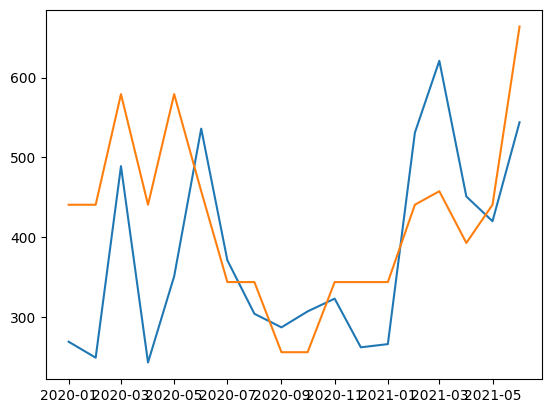

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

imputer = SimpleImputer()
transformed_df = pd.DataFrame(imputer.fit_transform(train_df), columns=list(train_df.columns))

clf = RandomForestRegressor(n_estimators=5, max_depth=3, random_state=0)
clf.fit(transformed_df[column_list], transformed_df.iloc[:,:1])

date_range = pd.date_range(start='2020-01-01', periods=18, freq='MS')
prediction = pd.DataFrame(clf.predict(X_df), index=date_range, columns=['prediction'])
mape_score = mape(test_df['sales_actuals_monthly__vehiclegroup01__orderintake'], prediction["prediction"])
print(mape_score)
plt.plot(test_df['sales_actuals_monthly__vehiclegroup01__orderintake'])
plt.plot(prediction["prediction"])
plt.show()